# Shipment Delay Prediction
This notebook features the process of selecting the best classification model for shipment delay. It includes exploratory data analysis, feature extraction, data cleaning and model training.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/MyDrive/Arogo AI Assignment/AI ML Internship Training Data.xlsx'

In [ ]:
df = pd.read_excel(dataset_path)
df.head(5)

,Shipment ID,Origin,Destination,Shipment Date,Planned Delivery Date,Actual Delivery Date,Vehicle Type,Distance (km),Weather Conditions,Traffic Conditions,Delayed
0,SHIP000000,Jaipur,Mumbai,2023-04-26,2023-05-01,2023-05-02,Trailer,1603,Rain,Light,Yes
1,SHIP000001,Bangalore,Delhi,2023-02-09,2023-02-13,2023-02-17,Trailer,1237,Storm,Moderate,Yes
2,SHIP000002,Mumbai,Chennai,2023-09-19,2023-09-25,2023-09-25,Truck,1863,Clear,Light,No
3,SHIP000003,Hyderabad,Ahmedabad,2023-04-01,2023-04-05,2023-04-05,Container,1374,Clear,Light,No
4,SHIP000004,Chennai,Kolkata,2023-11-24,2023-11-26,2023-11-28,Container,676,Clear,Heavy,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Shipment ID            20000 non-null  object        
 1   Origin                 20000 non-null  object        
 2   Destination            20000 non-null  object        
 3   Shipment Date          20000 non-null  datetime64[ns]
 4   Planned Delivery Date  20000 non-null  datetime64[ns]
 5   Actual Delivery Date   20000 non-null  datetime64[ns]
 6   Vehicle Type           19403 non-null  object        
 7   Distance (km)          20000 non-null  int64         
 8   Weather Conditions     20000 non-null  object        
 9   Traffic Conditions     20000 non-null  object        
 10  Delayed                20000 non-null  object        
dtypes: datetime64[ns](3), int64(1), object(7)
memory usage: 1.7+ MB


There are missing values in the ```Vehicle Type``` column.

In order to handle this, we'll first review the number of unique vehicles in the column and their quantities.

In [ ]:
df['Vehicle Type'].value_counts()

,count
Vehicle Type,
Lorry,4878
Truck,4860
Trailer,4838
Container,4827


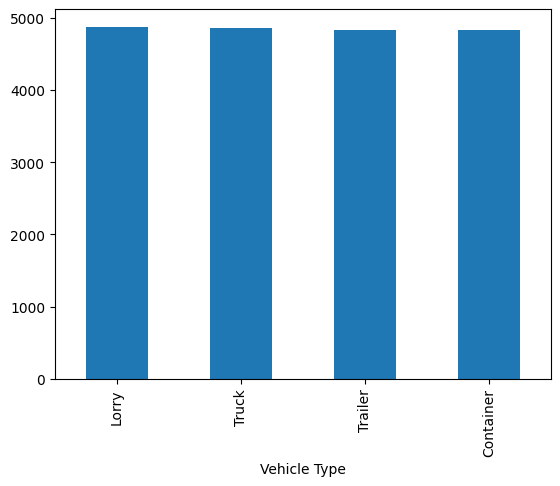

In [ ]:
df['Vehicle Type'].value_counts().plot(kind='bar')
plt.show()

There are 4 different types of vehicles being used for shipping -

1.   Lorry
2.   Truck
3.   Trailer
4.   Container


The number of shipments for each vehicle is between **4800 to 4900**, thus there is no imbalance in the dataset. Now, let's go through the entries with no vehicle i.e. null values.

In [ ]:
shipments_with_null_vehicles =  df[df['Vehicle Type'].isna()]
shipments_with_null_vehicles.head(10)

,Shipment ID,Origin,Destination,Shipment Date,Planned Delivery Date,Actual Delivery Date,Vehicle Type,Distance (km),Weather Conditions,Traffic Conditions,Delayed
66,SHIP000066,Hyderabad,Ahmedabad,2024-03-04,2024-03-08,2024-03-10,NaN,1311,Clear,Heavy,Yes
101,SHIP000101,Ahmedabad,Delhi,2023-05-27,2023-05-30,2023-05-31,NaN,1115,Clear,Moderate,Yes
120,SHIP000120,Bangalore,Mumbai,2023-05-12,2023-05-18,2023-05-19,NaN,1802,Clear,Moderate,Yes
126,SHIP000126,Kolkata,Chennai,2023-10-20,2023-10-21,2023-10-22,NaN,517,Clear,Moderate,Yes
131,SHIP000131,Lucknow,Chennai,2023-12-23,2023-12-25,2023-12-28,NaN,772,Clear,Moderate,Yes
137,SHIP000137,Mumbai,Hyderabad,2023-05-07,2023-05-08,2023-05-08,NaN,337,Clear,Light,No
153,SHIP000153,Bangalore,Hyderabad,2023-03-05,2023-03-06,2023-03-06,NaN,272,Clear,Light,No
189,SHIP000189,Jaipur,Kolkata,2024-05-15,2024-05-21,2024-05-24,NaN,1859,Fog,Moderate,Yes
201,SHIP000201,Lucknow,Mumbai,2023-04-28,2023-05-01,2023-05-03,NaN,1144,Clear,Heavy,Yes
215,SHIP000215,Lucknow,Mumbai,2023-04-07,2023-04-10,2023-04-16,NaN,1192,Rain,Light,Yes


In [ ]:
shipments_with_null_vehicles['Origin'].value_counts()

,count
Origin,
Pune,73
Bangalore,71
Chennai,66
Jaipur,62
Kolkata,60
Hyderabad,54
Lucknow,54
Ahmedabad,53
Mumbai,53


There are missing entries for all the 10 cities.

In order to impute values into the missing entries, we can find the most used vehicle for each origin city and impute that value.

In [ ]:
origin_vehicle_df = df.groupby(['Origin', 'Vehicle Type'])['Vehicle Type'].count().reset_index(name='Count')

max_count_per_origin = origin_vehicle_df.loc[origin_vehicle_df.groupby('Origin')['Count'].idxmax()].reset_index()
max_count_per_origin

,index,Origin,Vehicle Type,Count
0,1,Ahmedabad,Lorry,505
1,7,Bangalore,Truck,498
2,9,Chennai,Lorry,508
3,12,Delhi,Container,525
4,18,Hyderabad,Trailer,517
5,22,Jaipur,Trailer,483
6,24,Kolkata,Container,514
7,29,Lucknow,Lorry,519
8,34,Mumbai,Trailer,531
9,38,Pune,Trailer,537


In [ ]:
def generate_mapping(df):
  mapping = {}
  for idx, row in df.iterrows():
    mapping[row['Origin']] = row['Vehicle Type']

  return mapping

origin_vehicle_type_mapping = generate_mapping(max_count_per_origin)
origin_vehicle_type_mapping

{'Ahmedabad': 'Lorry',
 'Bangalore': 'Truck',
 'Chennai': 'Lorry',
 'Delhi': 'Container',
 'Hyderabad': 'Trailer',
 'Jaipur': 'Trailer',
 'Kolkata': 'Container',
 'Lucknow': 'Lorry',
 'Mumbai': 'Trailer',
 'Pune': 'Trailer'}

In [ ]:
# imputing these values in the dataframe
df['Vehicle Type'] = df.apply(lambda row: origin_vehicle_type_mapping[row['Origin']] \
                              if pd.isna(row['Vehicle Type']) else row['Vehicle Type'], \
                              axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Shipment ID            20000 non-null  object        
 1   Origin                 20000 non-null  object        
 2   Destination            20000 non-null  object        
 3   Shipment Date          20000 non-null  datetime64[ns]
 4   Planned Delivery Date  20000 non-null  datetime64[ns]
 5   Actual Delivery Date   20000 non-null  datetime64[ns]
 6   Vehicle Type           20000 non-null  object        
 7   Distance (km)          20000 non-null  int64         
 8   Weather Conditions     20000 non-null  object        
 9   Traffic Conditions     20000 non-null  object        
 10  Delayed                20000 non-null  object        
dtypes: datetime64[ns](3), int64(1), object(7)
memory usage: 1.7+ MB


Now, that we have imputed the missing entries in ```Vehicle Type```. Let's move onto the other columns in the dataset.
<br>

We have 3 raw datetime columns, however they cannot be used meaningfully by the model. So, let's extract new features from them.

In [ ]:
df['Shipment Year'] = df['Shipment Date'].dt.year
df['Shipment Month'] = df['Shipment Date'].dt.month
df['Shipment Day'] = df['Shipment Date'].dt.day
df['Shipment Day of Week'] = df['Shipment Date'].dt.dayofweek
df['Shipment Hour'] = df['Shipment Date'].dt.hour
df['Shipped on Weekday'] = df['Shipment Date'].dt.dayofweek < 5
df['Delivery Duration'] = (df['Actual Delivery Date'] - df['Shipment Date']).dt.days

df.drop(['Shipment Date', 'Planned Delivery Date', 'Actual Delivery Date'], axis=1, inplace=True)

df.head(5)

,Shipment ID,Origin,Destination,Vehicle Type,Distance (km),Weather Conditions,Traffic Conditions,Delayed,Shipment Year,Shipment Month,Shipment Day,Shipment Day of Week,Shipment Hour,Shipped on Weekday,Delivery Duration
0,SHIP000000,Jaipur,Mumbai,Trailer,1603,Rain,Light,Yes,2023,4,26,2,0,True,6
1,SHIP000001,Bangalore,Delhi,Trailer,1237,Storm,Moderate,Yes,2023,2,9,3,0,True,8
2,SHIP000002,Mumbai,Chennai,Truck,1863,Clear,Light,No,2023,9,19,1,0,True,6
3,SHIP000003,Hyderabad,Ahmedabad,Container,1374,Clear,Light,No,2023,4,1,5,0,False,4
4,SHIP000004,Chennai,Kolkata,Container,676,Clear,Heavy,Yes,2023,11,24,4,0,True,4


We have completed data cleaning and feature extraction. So, we can encode all our categorical columns and proceed towards model training.

In [ ]:
# before one hot encoding we'll label encode the target column and
# drop the 'Shipment ID' column since it is of no use to model
le = LabelEncoder()
df['Delayed'] = le.fit_transform(df['Delayed'])

df.drop(['Shipment ID'], axis=1, inplace=True)

In [ ]:
categorical_features = df.select_dtypes(include=['object']).columns

ohe = OneHotEncoder(sparse_output=False)
encoded_features = ohe.fit_transform(df[categorical_features])

encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(categorical_features))

df = pd.concat([df.drop(categorical_features, axis=1), encoded_df], axis=1)
df.head(5)

,Distance (km),Delayed,Shipment Year,Shipment Month,Shipment Day,Shipment Day of Week,Shipment Hour,Shipped on Weekday,Delivery Duration,Origin_Ahmedabad,Origin_Bangalore,Origin_Chennai,Origin_Delhi,Origin_Hyderabad,Origin_Jaipur,Origin_Kolkata,Origin_Lucknow,Origin_Mumbai,Origin_Pune,Destination_Ahmedabad,Destination_Bangalore,Destination_Chennai,Destination_Delhi,Destination_Hyderabad,Destination_Jaipur,Destination_Kolkata,Destination_Lucknow,Destination_Mumbai,Destination_Pune,Vehicle Type_Container,Vehicle Type_Lorry,Vehicle Type_Trailer,Vehicle Type_Truck,Weather Conditions_Clear,Weather Conditions_Fog,Weather Conditions_Rain,Weather Conditions_Storm,Traffic Conditions_Heavy,Traffic Conditions_Light,Traffic Conditions_Moderate
0,1603,1,2023,4,26,2,0,True,6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1237,1,2023,2,9,3,0,True,8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1863,0,2023,9,19,1,0,True,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1374,0,2023,4,1,5,0,False,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,676,1,2023,11,24,4,0,True,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df.describe()

,Distance (km),Delayed,Shipment Year,Shipment Month,Shipment Day,Shipment Day of Week,Shipment Hour,Delivery Duration,Origin_Ahmedabad,Origin_Bangalore,Origin_Chennai,Origin_Delhi,Origin_Hyderabad,Origin_Jaipur,Origin_Kolkata,Origin_Lucknow,Origin_Mumbai,Origin_Pune,Destination_Ahmedabad,Destination_Bangalore,Destination_Chennai,Destination_Delhi,Destination_Hyderabad,Destination_Jaipur,Destination_Kolkata,Destination_Lucknow,Destination_Mumbai,Destination_Pune,Vehicle Type_Container,Vehicle Type_Lorry,Vehicle Type_Trailer,Vehicle Type_Truck,Weather Conditions_Clear,Weather Conditions_Fog,Weather Conditions_Rain,Weather Conditions_Storm,Traffic Conditions_Heavy,Traffic Conditions_Light,Traffic Conditions_Moderate
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.00000,20000.0,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000
mean,1101.663750,0.737850,2023.297200,5.464750,15.72290,2.99650,0.0,5.205050,0.098750,0.101500,0.098950,0.102150,0.098850,0.095250,0.098650,0.096150,0.103900,0.105850,0.100600,0.101600,0.102100,0.099100,0.097650,0.102200,0.097100,0.101400,0.098800,0.099450,0.246900,0.252550,0.254000,0.246550,0.697600,0.100700,0.153350,0.04835,0.153600,0.497500,0.348900
std,520.717873,0.439815,0.457037,3.388323,8.86583,1.99321,0.0,2.584151,0.298334,0.301997,0.298602,0.302853,0.298468,0.293567,0.298199,0.294804,0.305138,0.307653,0.300806,0.302129,0.302787,0.298804,0.296848,0.302919,0.296101,0.301865,0.298401,0.299273,0.431219,0.434486,0.435308,0.431013,0.459309,0.300939,0.360334,0.21451,0.360574,0.500006,0.476634
min,200.000000,0.000000,2023.000000,1.000000,1.00000,0.00000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,649.750000,0.000000,2023.000000,3.000000,8.00000,1.00000,0.0,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,1102.000000,1.000000,2023.000000,5.000000,16.00000,3.00000,0.0,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,1551.000000,1.000000,2024.000000,8.000000,23.00000,5.00000,0.0,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000
max,2000.000000,1.000000,2024.000000,12.000000,31.00000,6.00000,0.0,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


We are done with preprocessing steps. Now, we'll proceed to model building where we will use **2** classification models: -
1. Logistic Regression
2. Decision Tree Classifier

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop('Delayed', axis=1), df['Delayed'], test_size=0.2, random_state=41)

## Logistic Regression

In [ ]:
# logistic regression is sensitive to wide data ranges thus we will
# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, Y_train)

LogisticRegression()

In [ ]:
Y_pred = log_reg.predict(X_test_scaled)
lr_accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy for Logistic Regression: {lr_accuracy}')

Accuracy for Logistic Regression: 0.99625


In [ ]:
lr_classification_report = classification_report(Y_test, Y_pred)
print(f'Classification report for Logistic Regression:')
print(lr_classification_report)

Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1091
           1       1.00      0.99      1.00      2909

    accuracy                           1.00      4000
   macro avg       0.99      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [ ]:
lr_confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(f'Confusion matrix for Logistic Regression:')
print(lr_confusion_matrix)

Confusion matrix for Logistic Regression:
[[1091    0]
 [  15 2894]]


## Decision Tree Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')
best_score = grid_search.best_score_
print(f'Best score: {best_score}')

Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best score: 0.9983124999999999


In [ ]:
dtc = grid_search.best_estimator_

In [ ]:
dtc.fit(X_train, Y_train)
Y_pred_dtc = dtc.predict(X_test)

dtc_accuracy = accuracy_score(Y_test, Y_pred_dtc)
print(f'Accuracy for Decision Tree Classifier: {dtc_accuracy}')

Accuracy for Decision Tree Classifier: 0.99625


In [ ]:
dtc_classification_report = classification_report(Y_test, Y_pred_dtc)
print(f'Classification report for Decision Tree Classifier:')
print(dtc_classification_report)

Classification report for Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1091
           1       1.00      0.99      1.00      2909

    accuracy                           1.00      4000
   macro avg       0.99      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [ ]:
dtc_confusion_matrix = confusion_matrix(Y_test, Y_pred_dtc)
print(f'Confusion matrix for Decision Tree Classifier:')
print(dtc_confusion_matrix)

Confusion matrix for Decision Tree Classifier:
[[1091    0]
 [  15 2894]]


## Model Comparison

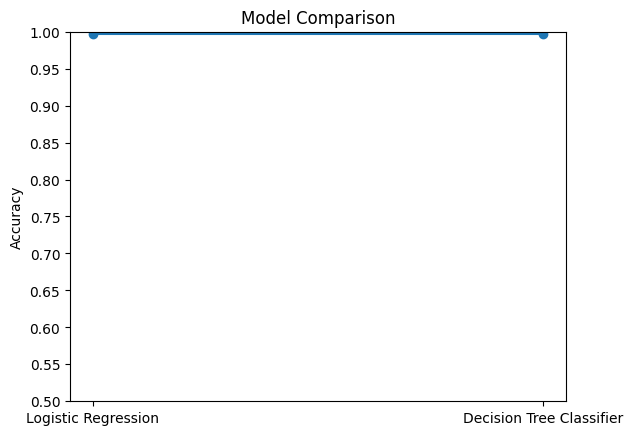

In [ ]:
plt.plot(['Logistic Regression', 'Decision Tree Classifier'], [lr_accuracy, dtc_accuracy], marker='o')
plt.ylim([0.5,1])
plt.yticks(np.arange(0.5, 1.05, 0.05))
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

Both the models have showed the same performance on all metrics including accuracy, precision, recall and F1 score. But, logistic regression is a comparatively simpler model.

Thus, the best course of action would be to select Logistic Regression for the task.

In [ ]:
import pickle

pickle.dump(log_reg, open('model.pkl', 'wb'))